In [50]:
import os
import sys
os.getcwd()

'C:\\Users\\speed\\Documents\\PHYS417_Project\\emma'

In [51]:
# importing libraries & making torch.device object for GPU

# neural network packages
import torch
import torch.nn as nn
from torch.nn import Transformer
from torch import Tensor
from torch.utils.data import DataLoader
sys.path.append('..\\..\\PHYS417_Project')
from nnrunner import NetRunner

# data packages
import numpy as np
import math
import pandas as pd
import sklearn.preprocessing as prep
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
import fndict as fd
import random
from concurrent.futures import ThreadPoolExecutor
from sklearn.preprocessing import StandardScaler

# visual packages
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import tqdm.notebook as tq
from tqdm.notebook import trange
import warnings

# Create a torch.device object to tell pytorch where to store your tensors: cpu or gpu
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

<b>About the Dataset</b>

<u>Tag</u>: the type of the original particles involved in the collision

<u>Jet</u>: collection of particles that hadronized (decayed) together into a stable particle

Per jet, variable number of constituents (rows) with 5 features (columns):
1. $p_T$: transverse momentum as a fraction of the jet total
2. $\eta$: angular coordinate relative to jet center
3. $\phi$: angular coordinate relative to jet center
4. $E$: energy from constituent
5. $\Delta R = \sqrt{\eta^2 + \phi^2}$

#### Preparing the Data

Normalization: Numerical data should be on a similar scale, typically between 0 and 1. This will help the model learn more efficiently. Use scaling such as Min-Max Scaling or Z-score normalization techniques

Imbalance: If some target classes have significantly more instances than others, the model may become biased towards the majority class. Try over-sampling the minority class or under-sampling the majority class to address this.

Sequence Length Uniformity: Since the sequences have varying lengths, padding or truncation will help to standardize them. This will ensure that the transformer model can handle the input effectively.

In [52]:
## loading data
def load_npz(file_path):
    data = np.load(file_path)
    x = data['x']
    y = data['y']
    data.close()
    return x, y

def pad_and_merge_npz_files(input_dir, output_file='./output.npz', num_files=100000, save=True):
    # Initialize lists to store x and y arrays
    x_list = []
    y_list = []

    # Get list of .npz files in the input directory, shuffle them
    npz_files = [os.path.join(input_dir, file_name) for file_name in os.listdir(input_dir) if file_name.endswith(".npz")]
    random.shuffle(npz_files)

    # Limit the number of files to process
    npz_files = npz_files[:num_files]

    # Create a ThreadPoolExecutor with a maximum of 4 threads
    with ThreadPoolExecutor(max_workers=12) as executor:
        # Submit tasks to the executor for parallel execution
        futures = [executor.submit(load_npz, file_path) for file_path in npz_files]

        # Display progress bar
        with tq.tqdm(total=len(npz_files), desc="Merging .npz files") as pbar:
            # Iterate over completed futures to retrieve results
            for future in futures:
                x, y = future.result()
                x_list.append(x)
                y_list.append(torch.tensor(torch.from_numpy(y), dtype=torch.float32).to(DEVICE))
                pbar.update(1)  # Update progress bar

    # Stack x matrices
    stacked_x = np.vstack(x_list)

    # Scale the data using StandardScaler
    scaler = StandardScaler()
    scaled_x = scaler.fit_transform(stacked_x)

    # Split normalized_x back into matrices
    num_matrices = len(x_list)
    start_idx = 0
    scaled_x_list = []
    for x_matrix in x_list:
        end_idx = start_idx + x_matrix.shape[0]
        scaled_x_list.append(torch.tensor(torch.from_numpy(scaled_x[start_idx:end_idx]), dtype=torch.float32).to(DEVICE))
        start_idx = end_idx

    return scaled_x_list, y_list

# Get the directory of the current script
current_dir = os.getcwd()
# Construct the path to the data folder
data_dir = os.path.join(current_dir, '..', 'data')
# Normalize the path (optional, but makes it more robust)
data_dir = os.path.normpath(data_dir)


x, y = pad_and_merge_npz_files(data_dir, save=False, num_files=20000)

Merging .npz files:   0%|          | 0/20000 [00:00<?, ?it/s]

C:\Users\speed\AppData\Local\Temp\ipykernel_11128\76731365.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_list.append(torch.tensor(torch.from_numpy(y), dtype=torch.float32).to(DEVICE))
C:\Users\speed\AppData\Local\Temp\ipykernel_11128\76731365.py:48: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  scaled_x_list.append(torch.tensor(torch.from_numpy(scaled_x[start_idx:end_idx]), dtype=torch.float32).to(DEVICE))


In [53]:
# ---- STEP 1: establishing training features (x) and training targets (y) data -----------------------
print("--Establishing Training Features/Targets--")

print("features (x):", len(x), "\ntargets (y):", len(y))


# ---- STEP 2: splitting data into training, validation, and testing sets -----------------------------
print("\n --Splitting Data--")

# shuffling for random selection, setting seed to 0 for reproduceability below
x, y = shuffle(x, y, random_state=0) 

# splitting data into training and testing sets
# the testing data is used to evaluate the model's performance after training for predictions on unseen data
# test_size = 0.2 means 20% of the data is for testing and 80% for training
trfeat, tefeat, trtarget, tetarget = train_test_split(x, y, test_size=0.2, random_state=0)

# splitting data again to get validation set
# the validation data is used to visualize/evaluate performance during training to help with tuning 
# 0.25 x 0.8 = 0.2
trfeat, vafeat, trtarget, vatarget = train_test_split(trfeat, trtarget, test_size=0.25, random_state=0) 

#for later
te2feat = tefeat
te2target = tetarget
print("Training set:", len(trfeat), len(trtarget))
print("Validation set:", len(vafeat), len(vatarget))
print("Testing set:", len(tefeat), len(tetarget))


''' DATA PRE-SCALED, NO NEED TO NORMALIZE '''

--Establishing Training Features/Targets--
features (x): 20000 
targets (y): 20000

 --Splitting Data--
Training set: 12000 12000
Validation set: 4000 4000
Testing set: 4000 4000


' DATA PRE-SCALED, NO NEED TO NORMALIZE '

#### Build Model & Initialize

In [54]:
class ParticleClassifier(nn.Module):
    def __init__(self, input_dim, num_classes, num_layers=2, num_heads=5, hidden_dim=256, hdim2=100, dropout=0.1):
        super(ParticleClassifier, self).__init__()
        
        # record dimensions and classes
        self.input_dim = input_dim
        self.num_classes = num_classes
        
        # Transformer Encoder
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=input_dim, nhead=num_heads, dim_feedforward=hidden_dim, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)
        
        # Fully connected layer for classification
        self.fc = nn.Linear(input_dim, hdim2)
        self.fc2 = nn.Linear(hdim2, num_classes)

        # Activation function
        self.relu = nn.ReLU()
        
    def forward(self, x):
        # x shape: (batch_size, seq_len, input_dim)
        x = x.permute(1, 0, 2)  # Change shape to (seq_len, batch_size, input_dim) for transformer
        x = self.transformer_encoder(x)
        x = x.mean(dim=0)  # Average pooling over sequence length
        x = self.relu(self.fc(x))
        output = self.fc2(x)
        output_probs = nn.functional.softmax(output, dim=1) # output probabilities with softmax
        return output_probs

# Hyperparameters
input_dim = 5  # Number of features per data point
num_classes = 5  # Number of output classes

# Initialize the model
classifier = ParticleClassifier(input_dim=input_dim, num_classes=num_classes, hdim2=100, num_heads=5, num_layers = 2).to(DEVICE)


C:\Users\speed\anaconda3\envs\phys417\Lib\site-packages\torch\nn\modules\transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


#### Train Model

<b>Hyperparameters</b>

Fair warning: you might get an "out of memory" error when training. If that happens, try reducing the batch size

betas are hyperparameters that control the exponential moving averages

eps is a small constant added to improve numerical stability by preventing division by zero

In [55]:
epochs = 25
batch_size = 500
learning_rate = 0.001
# learning_rate = 0.002
betas = (0.9, 0.98)
eps = 1e-8

In [56]:
def split_into_sublists(original_list, sublist_size=150):
    # Determine the number of full sublists
    print(len(original_list))
    num_full_sublists = len(original_list) // sublist_size
    print(num_full_sublists)
    
    # Create the full sublists
    sublists = [original_list[i*sublist_size:(i+1)*sublist_size] for i in range(num_full_sublists)]
    
    # ignore the residual list with remaining items  
    return sublists

# Split the training data into sublists
bfeatlist = split_into_sublists(trfeat, batch_size)
btarglist = split_into_sublists(trtarget,batch_size)

12000
24
12000
24


<b>Begin Training with Training Data</b>

In [57]:
from timeit import default_timer as timer

# Loss function and optimizer
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(classifier.parameters(), lr=learning_rate, betas=betas, eps=eps)

# Training Loop ---------------------------------------------------------------------------------------

trlosses = []
valosses = []


print(f'Learning Rate: {learning_rate} \nBatch Size: {batch_size} \nEpochs: {epochs} \n')
with warnings.catch_warnings(): # booo warnings
    # put the classifier in training mode
    classifier.train()
    warnings.simplefilter("ignore")
    
    start_time = timer()
    for epoch in tq.trange(epochs):
        # per epoch, iterate through the batches of training data
        for batchnum in tq.trange(len(btarglist)):
            optimizer.zero_grad()
            tpreds = []
            ttargs = []
            bfeats = bfeatlist[batchnum]
            btargs = btarglist[batchnum]

            # identifying the features and targets for the current batch
            for item, target in zip(bfeats, btargs):
                tpreds.append(classifier(item.unsqueeze(dim=0)))
                ttargs.append(target)
            
            train_outputs = torch.stack(tpreds, dim=0).squeeze(dim=1)
            targets = torch.stack(ttargs, dim=0)
            loss = loss_fn(train_outputs, targets)
            
            # track losses & repeat for next epoch!
            trlosses.append(loss.item())
            
            loss.backward()
            
            optimizer.step()

        # Compute Validation Accuracy ----------------------------------------------------------------------
        
        with torch.no_grad(): # Telling PyTorch we aren't passing inputs to network for training purpose
            vpreds = []
            v_targs = []

            # identifying the features and targets
            for item, target in zip(vafeat, vatarget):
                vpreds.append(classifier(item.unsqueeze(dim=0)))
                v_targs.append(target)
        
            v_outputs = torch.stack(vpreds, dim=0).squeeze(dim=1)
            v_targets = torch.stack(v_targs, dim=0)
            
            # track correct values
            correct = (torch.argmax(v_outputs, dim=1) == 
                    torch.argmax(v_targets, dim=1)).type(torch.FloatTensor)
            
            valosses.append(correct.mean())
    end_time = timer()
    time = end_time - start_time
    print(f"Total Train Time: {'{:.0f}m {:.1f}s'.format(*divmod(time, 60))}")

Learning Rate: 0.001 
Batch Size: 500 
Epochs: 25 


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

Total Train Time: 26m 42.6s


#### Assessing Training
**Overall accuracy**

In [58]:
tepreds = []
tetargs = []
with torch.no_grad(): # Telling PyTorch we aren't passing inputs to network for training purpose
    # identifying the features and targets
    for item, target in zip(tefeat, tetarget):
        tepreds.append(classifier(item.unsqueeze(dim=0)))
        tetargs.append(target)

# track correct values and calculate accuracy
te_outputs = torch.stack(tepreds, dim=0).squeeze(dim=1)
te_targets = torch.stack(tetargs, dim=0)
correct = (torch.argmax(te_outputs, dim=1) == 
        torch.argmax(te_targets, dim=1)).type(torch.FloatTensor)
accuracy = correct.mean().item()

te_outputs = te_outputs.cpu().numpy()
te_targets = te_targets.cpu().numpy()
pred = np.argmax(te_outputs, axis=1)
true = np.argmax(te_targets, axis=1)
cmat = confusion_matrix(pred,true)
print('model accuracy: ', accuracy)
print(cmat)

model accuracy:  0.6427500247955322
[[522 136  51  53  79]
 [114 538 107  90  16]
 [ 16  29 553 273  37]
 [ 23  24 101 365  73]
 [134  57   5  11 593]]


• Per jet, single classification:
• Gluon [0]
• Light quark[1]
• W boson[2]
• Z boson[3]
• Top quark[4]

<b>Visualizing Performance</b>

Test Accuracy: 64.275%


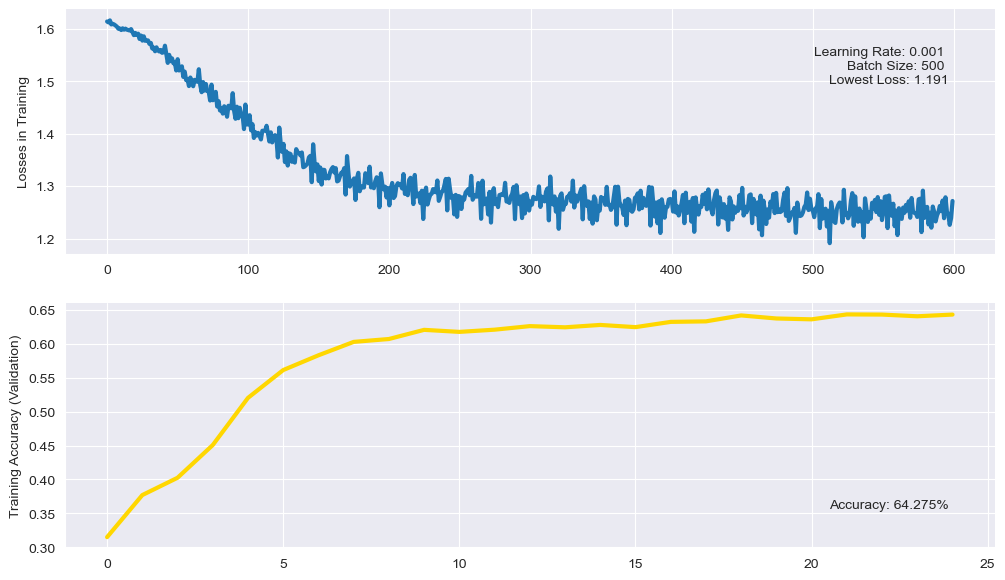

In [59]:
print(f'Test Accuracy: {accuracy*100:.3f}%')

# Plot the loss
plt.figure(figsize = (12, 7))

plt.subplot(2, 1, 1)
plt.plot(trlosses, linewidth = 3)
# plt.plot(runner.losses, linewidth = 3)
plt.ylabel("Losses in Training")
plt.annotate(f'Learning Rate: {learning_rate} \nBatch Size: {batch_size} \nLowest Loss: {min(trlosses):.3f}', 
             xy=(0.95, 0.85), xycoords='axes fraction', va='top', ha='right')
sns.despine()

plt.subplot(2, 1, 2)
plt.plot(valosses, linewidth = 3, color = 'gold')
# plt.plot(runner.accuracies, linewidth = 3, color = 'gold')
plt.ylabel("Training Accuracy (Validation)")
plt.annotate(f'Accuracy: {accuracy*100:.3f}%', xy=(0.95, 0.20), xycoords='axes fraction', va='top', ha='right')
sns.despine()

**Overall accuracy**

In [60]:
torch.save(classifier, './MODEL5_22_5.pth')

previous models:

In [61]:
classifier1 = torch.load('./MODEL5_21.pth')
tepreds = []
tetargs = []
with torch.no_grad(): # Telling PyTorch we aren't passing inputs to network for training purpose
    for item, target in zip(tefeat, tetarget):
        tepreds.append(classifier(item.unsqueeze(dim=0)))
        tetargs.append(target)

te_outputs = torch.stack(tepreds, dim=0).squeeze(dim=1)
te_targets = torch.stack(tetargs, dim=0)
correct = (torch.argmax(te_outputs, dim=1) == 
        torch.argmax(te_targets, dim=1)).type(torch.FloatTensor)
accuracy = correct.mean().item()

te_outputs = te_outputs.cpu().numpy()
te_targets = te_targets.cpu().numpy()
pred = np.argmax(te_outputs, axis=1)
true = np.argmax(te_targets, axis=1)
cmat = confusion_matrix(pred,true)
print('model accuracy: ', accuracy)
print(cmat)

model accuracy:  0.6420000195503235
[[519 147  45  59  81]
 [118 525 124  83  12]
 [ 16  34 548 260  35]
 [ 21  23  95 385  79]
 [135  55   5   5 591]]


In [62]:
classifier1 = torch.load('./MODEL5_22_2.pth')
tepreds = []
tetargs = []
with torch.no_grad(): # Telling PyTorch we aren't passing inputs to network for training purpose
    for item, target in zip(tefeat, tetarget):
        tepreds.append(classifier(item.unsqueeze(dim=0)))
        tetargs.append(target)

te_outputs = torch.stack(tepreds, dim=0).squeeze(dim=1)
te_targets = torch.stack(tetargs, dim=0)
correct = (torch.argmax(te_outputs, dim=1) == 
        torch.argmax(te_targets, dim=1)).type(torch.FloatTensor)
accuracy = correct.mean().item()

te_outputs = te_outputs.cpu().numpy()
te_targets = te_targets.cpu().numpy()
pred = np.argmax(te_outputs, axis=1)
true = np.argmax(te_targets, axis=1)
cmat = confusion_matrix(pred,true)
print('model accuracy: ', accuracy)
print(cmat)

model accuracy:  0.6432499885559082
[[516 144  49  53  79]
 [122 532 115  82  12]
 [ 13  31 540 255  35]
 [ 20  23 108 396  83]
 [138  54   5   6 589]]


In [63]:
classifier1 = torch.load('./MODEL5_22_3.pth')
tepreds = []
tetargs = []
with torch.no_grad(): # Telling PyTorch we aren't passing inputs to network for training purpose
    for item, target in zip(tefeat, tetarget):
        tepreds.append(classifier(item.unsqueeze(dim=0)))
        tetargs.append(target)

te_outputs = torch.stack(tepreds, dim=0).squeeze(dim=1)
te_targets = torch.stack(tetargs, dim=0)
correct = (torch.argmax(te_outputs, dim=1) == 
        torch.argmax(te_targets, dim=1)).type(torch.FloatTensor)
accuracy = correct.mean().item()

te_outputs = te_outputs.cpu().numpy()
te_targets = te_targets.cpu().numpy()
pred = np.argmax(te_outputs, axis=1)
true = np.argmax(te_targets, axis=1)
cmat = confusion_matrix(pred,true)
print('model accuracy: ', accuracy)
print(cmat)

model accuracy:  0.6420000195503235
[[521 138  46  57  74]
 [115 527 121  84  17]
 [ 13  35 545 264  37]
 [ 23  28 100 382  77]
 [137  56   5   5 593]]


In [64]:
classifier1 = torch.load('./MODEL5_22_5.pth')
tepreds = []
tetargs = []
with torch.no_grad(): # Telling PyTorch we aren't passing inputs to network for training purpose
    for item, target in zip(tefeat, tetarget):
        tepreds.append(classifier(item.unsqueeze(dim=0)))
        tetargs.append(target)

te_outputs = torch.stack(tepreds, dim=0).squeeze(dim=1)
te_targets = torch.stack(tetargs, dim=0)
correct = (torch.argmax(te_outputs, dim=1) == 
        torch.argmax(te_targets, dim=1)).type(torch.FloatTensor)
accuracy = correct.mean().item()

te_outputs = te_outputs.cpu().numpy()
te_targets = te_targets.cpu().numpy()
pred = np.argmax(te_outputs, axis=1)
true = np.argmax(te_targets, axis=1)
cmat = confusion_matrix(pred,true)
print('model accuracy: ', accuracy)
print(cmat)

model accuracy:  0.6380000114440918
[[514 146  49  54  82]
 [121 521 112  89  11]
 [ 16  34 550 263  40]
 [ 21  29 100 375  73]
 [137  54   6  11 592]]
